## Importation des bibliotheques

In [1]:
import os
import shutil
import random
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report
from collections import Counter
from tqdm import tqdm


## verification du gpu

In [2]:
print("GPU disponible :", torch.cuda.is_available())
print("Nom du GPU :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Aucun")


GPU disponible : True
Nom du GPU : Tesla T4


## Chargement des donnees

In [3]:
base_dir = '/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset/african_plums'
classes = os.listdir(base_dir)
print("Classes :", classes)

# Nombre d’images par classe
for cls in classes:
    n_images = len(os.listdir(os.path.join(base_dir, cls)))
    print(f"{cls}: {n_images} images")

Classes : ['unripe', 'cracked', 'rotten', 'spotted', 'bruised', 'unaffected']
unripe: 826 images
cracked: 162 images
rotten: 720 images
spotted: 759 images
bruised: 319 images
unaffected: 1721 images


## Découpage train / val / test

In [4]:
output_dir = '/kaggle/working/african_plums_split'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

split_ratios = (0.8, 0.1, 0.1)

if not os.path.exists(output_dir):
    for cls in classes:
        paths = os.listdir(os.path.join(base_dir, cls))
        random.shuffle(paths)
        n_total = len(paths)
        n_train = int(split_ratios[0] * n_total)
        n_val = int(split_ratios[1] * n_total)

        cls_paths = {
            train_dir: paths[:n_train],
            val_dir: paths[n_train:n_train+n_val],
            test_dir: paths[n_train+n_val:]
        }

        for split_dir, imgs in cls_paths.items():
            dest_dir = os.path.join(split_dir, cls)
            os.makedirs(dest_dir, exist_ok=True)
            for img in imgs:
                shutil.copy(os.path.join(base_dir, cls, img), os.path.join(dest_dir, img))


## Oversampling & Data Augmentation

In [5]:
IMG_SIZE = 224

base_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmented_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3, 0.3, 0.3),
    transforms.RandomRotation(20),
    base_transform
])

class BalancedDataset(ImageFolder):
    def __getitem__(self, index):
        path, label = self.samples[index]
        image = self.loader(path)
        if self.class_to_idx[self.classes[label]] in self.minority_classes:
            if torch.rand(1) < 0.75:
                return augmented_transform(image), label
        if torch.rand(1) < 0.5:
            return augmented_transform(image), label
        else:
            return base_transform(image), label

train_dataset_raw = ImageFolder(train_dir)
class_counts = Counter([label for _, label in train_dataset_raw.samples])
mean_count = np.mean(list(class_counts.values()))
minority_classes = [cls for cls, count in class_counts.items() if count < mean_count]

train_dataset = BalancedDataset(train_dir)
train_dataset.minority_classes = minority_classes
train_dataset.transform = None

targets = [label for _, label in train_dataset.samples]
weights = 1. / np.bincount(targets)[targets]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)


## Chargement du modèle CoAtNet

In [6]:
!pip install -q git+https://github.com/rwightman/pytorch-image-models.git
import timm

model = timm.create_model('coat_lite_medium', pretrained=True, num_classes=len(classes))


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Résumé du modèle

In [7]:
print(model)

CoaT(
  (patch_embed1): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (patch_embed2): PatchEmbed(
    (proj): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (patch_embed3): PatchEmbed(
    (proj): Conv2d(256, 320, kernel_size=(2, 2), stride=(2, 2))
    (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
  )
  (patch_embed4): PatchEmbed(
    (proj): Conv2d(320, 512, kernel_size=(2, 2), stride=(2, 2))
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (cpe1): ConvPosEnc(
    (proj): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
  )
  (cpe2): ConvPosEnc(
    (proj): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
  )
  (cpe3): ConvPosEnc(
    (proj): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), gr

## Paramétrage du modèle

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


## Préparation des dataloaders

In [9]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(ImageFolder(val_dir, transform=base_transform), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(ImageFolder(test_dir, transform=base_transform), batch_size=BATCH_SIZE, shuffle=False)


## Entraînement

In [10]:
EPOCHS = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    model.train()
    correct, total, running_loss = 0, 0, 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    correct, total, running_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


100%|██████████| 113/113 [03:03<00:00,  1.62s/it]


Epoch 1/10 - Train Loss: 1.0145, Train Acc: 0.6162 | Val Loss: 0.9467, Val Acc: 0.6518


100%|██████████| 113/113 [03:09<00:00,  1.67s/it]


Epoch 2/10 - Train Loss: 0.6349, Train Acc: 0.7666 | Val Loss: 0.8567, Val Acc: 0.7277


100%|██████████| 113/113 [03:09<00:00,  1.68s/it]


Epoch 3/10 - Train Loss: 0.5237, Train Acc: 0.8188 | Val Loss: 0.9171, Val Acc: 0.6964


100%|██████████| 113/113 [03:08<00:00,  1.67s/it]


Epoch 4/10 - Train Loss: 0.4574, Train Acc: 0.8407 | Val Loss: 0.9426, Val Acc: 0.7366


100%|██████████| 113/113 [03:08<00:00,  1.67s/it]


Epoch 5/10 - Train Loss: 0.4061, Train Acc: 0.8562 | Val Loss: 0.9344, Val Acc: 0.7121


100%|██████████| 113/113 [03:08<00:00,  1.67s/it]


Epoch 6/10 - Train Loss: 0.3796, Train Acc: 0.8626 | Val Loss: 0.9737, Val Acc: 0.7098


100%|██████████| 113/113 [03:09<00:00,  1.68s/it]


Epoch 7/10 - Train Loss: 0.3442, Train Acc: 0.8743 | Val Loss: 1.0130, Val Acc: 0.7277


100%|██████████| 113/113 [03:08<00:00,  1.66s/it]


Epoch 8/10 - Train Loss: 0.3199, Train Acc: 0.8795 | Val Loss: 0.9593, Val Acc: 0.7500


100%|██████████| 113/113 [03:08<00:00,  1.67s/it]


Epoch 9/10 - Train Loss: 0.3004, Train Acc: 0.8868 | Val Loss: 1.0516, Val Acc: 0.7210


100%|██████████| 113/113 [03:09<00:00,  1.68s/it]


Epoch 10/10 - Train Loss: 0.2622, Train Acc: 0.9045 | Val Loss: 1.1291, Val Acc: 0.7388


## Affichage des courbes

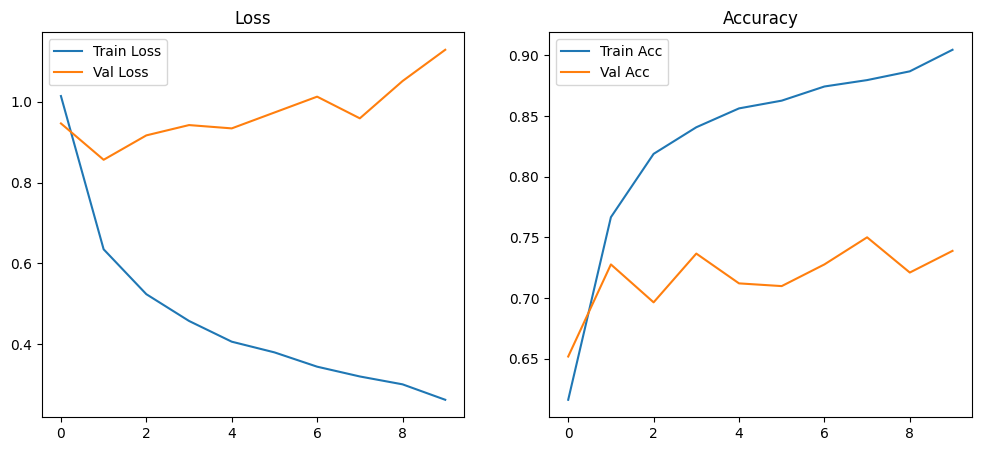

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend(); plt.title("Accuracy")
plt.show()


## Evaluation finale

In [12]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=classes))


              precision    recall  f1-score   support

      unripe       0.50      0.33      0.40        33
     cracked       0.60      0.71      0.65        17
      rotten       0.83      0.82      0.83        72
     spotted       0.58      0.64      0.61        77
     bruised       0.80      0.83      0.82       173
  unaffected       0.79      0.75      0.77        84

    accuracy                           0.74       456
   macro avg       0.68      0.68      0.68       456
weighted avg       0.74      0.74      0.74       456



In [1]:
print('hello')

hello
